Estudo parametrico de um algoritmo imunológico em um problema de classificação

In [3]:
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=804b998e5b2827aa63897c87b9224d592444bc193041b052675e7566c1df64a6
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from numpy import random
import clonalg
import pandas as pd
from sklearn import preprocessing

Anticorpos treinados com exemplos de iris virginica [label 2]

In [ ]:
df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

#Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

#Train dataset
train = train.join(labels)
# O valor de train[4] define qual label será utilizada para o treino da população
train = train.loc[train[4] == 0]
train = train.drop(columns=[4])

Métodos de normalização além do StandartScaler deverão ser testados

In [ ]:
feature_num = len(train.axes[1])
feature_max = train.max()
feature_max  = feature_max.max()
feature_min = train.min()
feature_min  = feature_min.min()

Definição de hiperparâmetros

In [ ]:
population_size = 250
selection_size = 70
memory_set_percentage = 20

clone_rate = 30
mutation_rate = 0.2
stop_codition = 100

random_cells_num = 100

d = 15
sigma1 = 0.4
sigma2 = 0.4

Conversão de dataframe para numpy array

In [ ]:
train = train.to_numpy()

![](https://github.com/pedrordrigs/Tr-iaNET/blob/master/resources/V7zasui.png?raw=1)

In [ ]:
stop = 0
population = clonalg.create_random_cells(population_size, feature_num, feature_min, feature_max)

while stop != stop_codition:
    # 1.
    for antigen in train:
        # 1.1
        population_affinity = [(cell, clonalg.affinity(cell, antigen)) for cell in population]
        # 1.2
        population_affinity = sorted(population_affinity, key=lambda x: abs(x[1]))
        best_affinity = population_affinity[:selection_size]
        # 1.3
        clone_population = []
        for cell in best_affinity:
            cell_clones = clonalg.clone(cell, clone_rate)
            clone_population += cell_clones
        # 1.4 - 1.5
        mutaded_clone_population = []
        for cell in clone_population:
            mutated_clone = clonalg.hypermutate_variability(cell, mutation_rate, antigen)
            mutaded_clone_population.append(mutated_clone)
        # 1.6
        mutaded_clone_population.sort(key=lambda x: x[1])
        pop_size = round(len(clone_population)/100)*memory_set_percentage

        mutaded_clone_population = mutaded_clone_population[0:pop_size]

        # 1.7
        filtered_clone_population = list(filter(lambda x: x[1] > sigma2, mutaded_clone_population))

        # 1.8
        remaining_clone_population = clonalg.remove_similar_clones(filtered_clone_population, sigma1)

        # 1.9
        # Remova o atributo de afinidade das células em remaining_clone_population
        remaining_clone_population_no_affinity = [(cell[0],) for cell in remaining_clone_population]
        # Adicione remaining_clone_population_no_affinity à população
        population += remaining_clone_population_no_affinity

    # 2.0
    population = clonalg.suppress_similar_cells(population, sigma1)
        
    # 3
    new_cells = clonalg.create_random_cells(int(population_size * (d / 100)), feature_num, feature_min, feature_max)
    population += new_cells
    print("População: ", len(population), "     Iteração: ", stop)
    stop += 1

## Solução temporária para nested arrays nos indivíduos da população.

for i, cell in enumerate(population):
    # Verifica se a célula tem mais de uma dimensão
    if len(cell[0].shape) > 1:
        # Aplica numpy.ravel() para simplificar as dimensões
        flattened_cell = np.ravel(cell[0])
        population[i] = (flattened_cell,)
    else:
        population[i] = cell
        
    if isinstance(cell, tuple):
        array_cell = np.array(cell)
        flattened_cell = np.ravel(array_cell)
        population[i] = (flattened_cell)


População:  40      Iteração:  0
População:  40      Iteração:  1
População:  39      Iteração:  2
População:  39      Iteração:  3
População:  38      Iteração:  4
População:  42      Iteração:  5
População:  42      Iteração:  6
População:  42      Iteração:  7


KeyboardInterrupt: 

In [ ]:
np.shape(population)

(49, 4)

In [ ]:
for i, cell in enumerate(population):
    # Verifica se a célula tem mais de uma dimensão
    if len(cell[0].shape) > 1:
        # Aplica numpy.ravel() para simplificar as dimensões
        flattened_cell = np.ravel(cell[0])
        population[i] = (flattened_cell,)
    else:
        population[i] = cell
        
    if isinstance(cell, tuple):
        array_cell = np.array(cell)
        flattened_cell = np.ravel(array_cell)
        population[i] = (flattened_cell)

In [ ]:
antibodies = pd.DataFrame(population)
antibodies = pd.DataFrame(scaler.inverse_transform(antibodies), columns=antibodies.columns)
antibodies_array = antibodies.values

In [ ]:
antibodies

,0,1,2,3
0,7.056963,2.689894,4.481173,0.529986
1,5.783053,3.099371,6.873208,0.086525
2,6.020507,2.281353,5.813985,1.324810
3,6.931965,4.098595,4.871270,1.250957
4,5.249956,4.000770,6.027077,0.016499
5,4.982227,3.818069,6.365284,0.016499
6,4.993918,2.367426,5.628922,0.956959
7,5.204095,2.854844,3.688458,1.877436
8,6.069907,4.291060,4.640457,0.066122
9,5.961348,4.414011,4.842150,0.282525


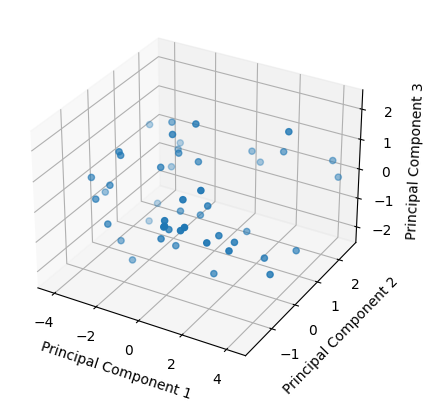

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.decomposition import PCA

# Extract the feature vectors from the population
feature_vectors = np.array([cell for cell in antibodies_array])


# Apply PCA to reduce the dimensionality to 3
pca = PCA(n_components=3)
reduced_population = pca.fit_transform(feature_vectors)

# Now, you can plot the reduced population using a 3D scatter plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = reduced_population[:, 0]
y = reduced_population[:, 1]
z = reduced_population[:, 2]

ax.scatter(x, y, z)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

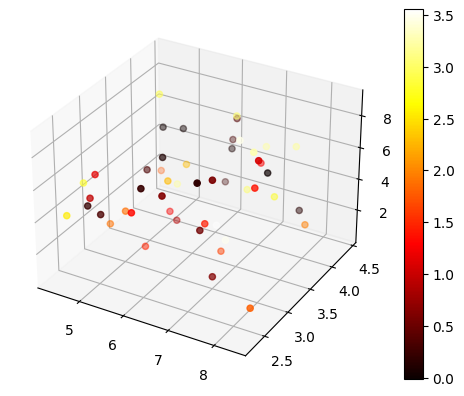

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

feature_vectors = np.array([cell for cell in antibodies_array])

x = feature_vectors[:, 0]
y = feature_vectors[:, 1]
z = feature_vectors[:, 2]
c = feature_vectors[:, 3]

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

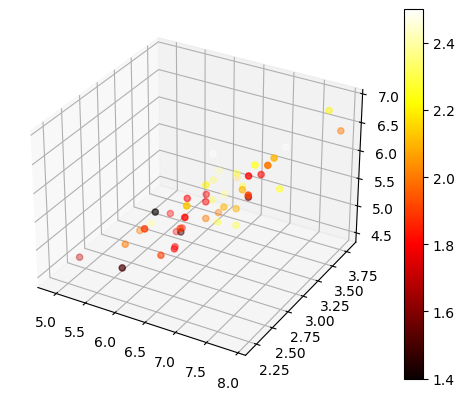

In [ ]:
df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

#Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(df)

#Train dataset
train = train.join(labels)
train = train.loc[train[4] == 2]
train = train.drop(columns=[4])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

train_array = train.values

feature_vectors = np.array([cell for cell in train_array])

x = feature_vectors[:, 0]
y = feature_vectors[:, 1]
z = feature_vectors[:, 2]
c = feature_vectors[:, 3]

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

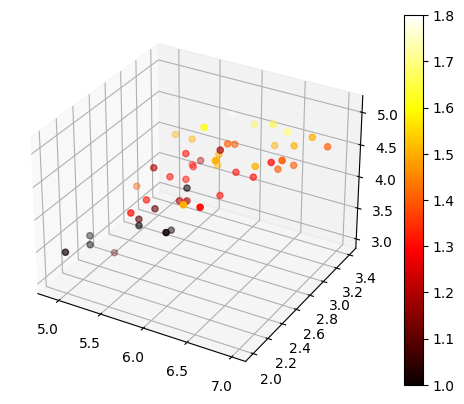

In [ ]:
df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

#Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(df)

#Train dataset
train = train.join(labels)
train = train.loc[train[4] == 1]
train = train.drop(columns=[4])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

train_array = train.values

feature_vectors = np.array([cell for cell in train_array])

x = feature_vectors[:, 0]
y = feature_vectors[:, 1]
z = feature_vectors[:, 2]
c = feature_vectors[:, 3]

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

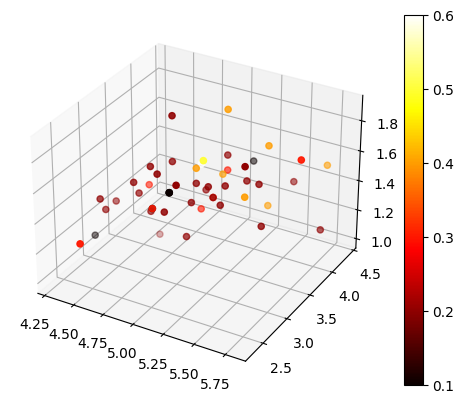

In [ ]:
df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

#Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(df)

#Train dataset
train = train.join(labels)
train = train.loc[train[4] == 0]
train = train.drop(columns=[4])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

train_array = train.values

feature_vectors = np.array([cell for cell in train_array])

x = feature_vectors[:, 0]
y = feature_vectors[:, 1]
z = feature_vectors[:, 2]
c = feature_vectors[:, 3]

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [ ]:
import pandas as pd
from sklearn import preprocessing
from train_loop import train_ais_classifier

In [ ]:
df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

# Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
train = train.join(labels)

In [ ]:
feature_num = train.shape[1] - 1  # Menos a coluna de labels
feature_min = train.iloc[:, :-1].min().min()  # Menos a coluna de labels
feature_max = train.iloc[:, :-1].max().max()  # Menos a coluna de labels

# Treine o classificador AIS para cada classe (0, 1, 2) e armazene os resultados em uma lista
trained_populations = []
for class_label in range(3):
    train_class = train.loc[train[4] == class_label]
    train_class = train_class.drop(columns=[4])
    train_class = train_class.to_numpy()
    population = train_ais_classifier(train_class, feature_num, feature_min, feature_max)
    trained_populations.append(population)

População:  53      Iteração:  0
População:  45      Iteração:  1
População:  43      Iteração:  2
População:  42      Iteração:  3
População:  46      Iteração:  4
População:  53      Iteração:  5
População:  56      Iteração:  6
População:  53      Iteração:  7
População:  48      Iteração:  8
População:  49      Iteração:  9
População:  51      Iteração:  10
População:  50      Iteração:  11
População:  53      Iteração:  12
População:  51      Iteração:  13
População:  53      Iteração:  14
População:  58      Iteração:  15
População:  61      Iteração:  16
População:  58      Iteração:  17
População:  55      Iteração:  18
População:  53      Iteração:  19
População:  53      Iteração:  20
População:  53      Iteração:  21
População:  57      Iteração:  22
População:  60      Iteração:  23
População:  57      Iteração:  24
População:  51      Iteração:  25
População:  52      Iteração:  26
População:  50      Iteração:  27
População:  56      Iteração:  28
População:  56      Iter

In [ ]:
from sklearn.model_selection import train_test_split
import clonalg
from train_loop import multiclass_performance_measure

df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

# Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
train = train.join(labels)
# Dividir o conjunto de dados em treino e teste
train_data, test_data = train_test_split(train, test_size=0.3, random_state=42)

test_data_array = test_data.values
performance = multiclass_performance_measure(trained_populations, test_data_array)
print(f"Desempenho do classificador AIS: {performance * 100:.2f}%")


Desempenho do classificador AIS: 28.89%


Multithread

In [31]:
from train_loop import train_clonalg_parallel
from train_loop import multiclass_performance_measure
from sklearn.model_selection import train_test_split
from train_loop import multiclass_performance_measure
import pandas as pd
from sklearn import preprocessing

df = pd.read_csv('dataset/iris.csv', header=None)

df[4] = pd.Categorical(df[4]).codes
labels = df[[4]].copy()

df = df.drop(columns=[4])

# Standard Scaler
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
train = train.join(labels)
# Dividir o conjunto de dados em treino e teste
train_data, test_data = train_test_split(train, test_size=0.3, random_state=42)

params = {
    'population_size': 250,
    'selection_size': 30,
    'memory_set_percentage': 30,
    'clone_rate': 30,
    'mutation_rate': 0.3,
    'stop_condition': 50,
    'd': 15,
    'sigma1': 0.2,
    'sigma2': 0.2,
    'feature_num': train_data.shape[1] - 1,
    'feature_min': train_data.min().min(),
    'feature_max': train_data.max().max(),
}

trained_populations = train_clonalg_parallel(train_data, params, [0, 1, 2])

# Avaliar o desempenho do classificador AIS
test_data_array = test_data.values
performance = multiclass_performance_measure(trained_populations, test_data_array)
print(f"Desempenho do classificador AIS: {performance * 100:.2f}%")

População:  109      Iteração:  0
População:  165      Iteração:  0
População:  113      Iteração:  0
População:  95      Iteração:  1
População:  157      Iteração:  1
População:  98      Iteração:  1
População:  85      Iteração:  2
População:  158      Iteração:  2
População:  83      Iteração:  3
População:  79      Iteração:  2
População:  69      Iteração:  4
População:  82      Iteração:  5
População:  99      Iteração:  3
População:  134      Iteração:  3
População:  106      Iteração:  4
População:  129      Iteração:  4
População:  89      Iteração:  6
População:  125      Iteração:  5
População:  92      Iteração:  5
População:  93      Iteração:  7
População:  78      Iteração:  6
População:  140      Iteração:  6
População:  97      Iteração:  8
População:  94      Iteração:  7
População:  148      Iteração:  7
População:  87      Iteração:  9
População:  106      Iteração:  8
População:  152      Iteração:  8
População:  88      Iteração:  10
População:  83      Iteração:

In [3]:
type(test_data_array)

numpy.ndarray

In [40]:
from train_loop import multiclass_performance_measure_tolerance
tolerance = 1.8
test_data_array = test_data.values
performance = multiclass_performance_measure_tolerance(trained_populations, test_data_array, tolerance)
print(f"Desempenho do classificador AIS: {performance * 100:.2f}%")

Desempenho do classificador AIS: 86.67%


In [ ]:
import numpy as np
import clonalg

def train_ais_classifier(train, feature_num, feature_min, feature_max, population_size=500, selection_size=70, memory_set_percentage=20, clone_rate=30, mutation_rate=0.2, stop_condition=50, d=15, sigma1=0.4, sigma2=0.4):
    stop = 0
    population = clonalg.create_random_cells(population_size, feature_num, feature_min, feature_max)

    while stop != stop_condition:
        for antigen in train:
            population_affinity = [(cell, clonalg.affinity(cell, antigen)) for cell in population]
            population_affinity = sorted(population_affinity, key=lambda x: abs(x[1]))
            best_affinity = population_affinity[:selection_size]

            clone_population = []
            for cell in best_affinity:
                cell_clones = clonalg.clone(cell, clone_rate)
                clone_population += cell_clones

            mutated_clone_population = []
            for cell in clone_population:
                mutated_clone = clonalg.hypermutate_variability(cell, mutation_rate, antigen)
                mutated_clone_population.append(mutated_clone)

            mutated_clone_population.sort(key=lambda x: x[1])
            pop_size = round(len(clone_population) / 100) * memory_set_percentage
            mutated_clone_population = mutated_clone_population[:pop_size]

            filtered_clone_population = list(filter(lambda x: x[1] > sigma2, mutated_clone_population))
            remaining_clone_population = clonalg.remove_similar_clones(filtered_clone_population, sigma1)

            remaining_clone_population_no_affinity = [(cell[0],) for cell in remaining_clone_population]
            population += remaining_clone_population_no_affinity

        population = clonalg.suppress_similar_cells(population, sigma1)

        new_cells = clonalg.create_random_cells(int(population_size * (d / 100)), feature_num, feature_min, feature_max)
        population += new_cells
        print("População: ", len(population), "     Iteração: ", stop)
        stop += 1

    for i, cell in enumerate(population):
        if len(cell[0].shape) > 1:
            flattened_cell = np.ravel(cell[0])
            population[i] = (flattened_cell,)
        else:
            population[i] = cell

        if isinstance(cell, tuple):
            array_cell = np.array(cell)
            flattened_cell = np.ravel(array_cell)
            population[i] = (flattened_cell)

    return population


def train_clonalg_parallel(train_data, params, classes):
    def train_clonalg_single_class(train_data, params, target_class):
        # Filtrar dados de treino para a classe alvo
        train_subset = train_data.loc[train_data[train_data.columns[-1]] == target_class].drop(columns=[train_data.columns[-1]])
        # Treinar a população usando os dados filtrados
        train_subset_array = train_subset.values
        population = train_ais_classifier(train_subset_array, **params)
        return population
    
    trained_populations = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(train_clonalg_single_class, train_data, params, class_label) for class_label in classes]
        for future in concurrent.futures.as_completed(futures):
            trained_populations.append(future.result())

    return trained_populations


import numpy as np

def multiclass_performance_measure(populations, test_data):
    correct_classifications = 0
    total_samples = test_data.shape[0]

    for row in test_data:
        sample_features = row[:-1]
        true_label = int(row[-1])

        class_scores = []
        for population in populations:
            if population:
                class_score = sum(clonalg.affinity(cell, sample_features) for cell in population)
                class_scores.append(class_score)
            else:
                class_scores.append(0)

        predicted_label = class_scores.index(max(class_scores))

        if predicted_label == true_label:
            correct_classifications += 1

    return correct_classifications / total_samples

import concurrent.futures


import clonalg

def multiclass_performance_measure_tolerance(populations, test_data, tolerance):
    correct_classifications = 0
    total_samples = test_data.shape[0]

    for row in test_data:
        sample_features = row[:-1]
        true_label = int(row[-1])

        class_scores = []
        for population in populations:
            if population:
                class_score = sum(clonalg.affinity(cell, sample_features) for cell in population if clonalg.affinity(cell, sample_features) <= tolerance)
                class_scores.append(class_score)
            else:
                class_scores.append(0)

        predicted_label = class_scores.index(max(class_scores))

        if predicted_label == true_label:
            correct_classifications += 1

    return correct_classifications / total_samples


